# Mount Google Drive

In [178]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Getting Embeddings

In [219]:
import os, numpy as np, pandas as pd

list_of_cog_embeds = pd.read_csv('/content/drive/Shareddrives/ECS289L/embeddings/cog/embeddings_full.csv')
list_of_gen_embeds = pd.read_csv('/content/drive/Shareddrives/ECS289L/embeddings/genetics_mlp/embeddings.csv')
list_of_mri_embeds = pd.read_csv('/content/drive/Shareddrives/ECS289L/embeddings/mri/embeddings.csv')

Converting Embeddings into Tensors

In [180]:
import torch
from tqdm import tqdm

cog_embeddings = []
gen_embeddings = []
mri_embeddings = []

c_rids = []
g_rids = []
m_rids = []

for _, row in tqdm(list_of_cog_embeds.iterrows(), total=len(list_of_cog_embeds), desc="Loading cog embeddings"):
    cog_embedding = np.load(row['path'])
    cog_embeddings.append(torch.tensor(cog_embedding, dtype=torch.float32))
    c_rids.append(row['RID'])

for _, row in tqdm(list_of_gen_embeds.iterrows(), total=len(list_of_gen_embeds), desc="Loading gen embeddings"):
    gen_embedding = np.load(row['path'])
    gen_embeddings.append(torch.tensor(gen_embedding, dtype=torch.float32))
    g_rids.append(row['RID'])

for _, row in tqdm(list_of_mri_embeds.iterrows(), total=len(list_of_mri_embeds), desc="Loading mri embeddings"):
    mri_embedding = np.load(row['path'])
    mri_embeddings.append(torch.tensor(mri_embedding, dtype=torch.float32))
    m_rids.append(row['RID'])

Loading mri embeddings: 100%|██████████| 210/210 [00:00<00:00, 253.57it/s]


Stacking Tensors

In [181]:
C_fused = torch.stack(cog_embeddings)  # shape: [N, D]
print(C_fused.shape)
G_fused = torch.stack(gen_embeddings)  # shape: [N, D]
print(G_fused.shape)
M_fused = torch.stack(mri_embeddings)  # shape: [N, D]
print(M_fused.shape)

torch.Size([1214, 32])
torch.Size([482, 128])
torch.Size([210, 128])


Merging with Labels

In [182]:
label_map = {0: "sMCI", 1: "pMCI"}
list_of_labels = pd.read_csv('/content/drive/Shareddrives/ECS289L/master_subjects.csv')

In [183]:
print(list_of_labels)

        RID  pMCI
0         4     0
1         6     0
2        30     1
3        33     0
4        38     0
...     ...   ...
1209  10523     0
1210  10530     0
1211  10533     0
1212  10561     0
1213  10627     0

[1214 rows x 2 columns]


In [184]:
# Create RID → label dictionary
rid_to_label = dict(zip(list_of_labels['RID'], list_of_labels['pMCI']))

# Generate the label tensor by mapping each RID from your embeddings list
labels = [rid_to_label[rid] for rid in c_rids]
c_labels = torch.tensor(labels, dtype=torch.long)

g_labels = torch.tensor([rid_to_label[rid] for rid in g_rids], dtype=torch.long)
m_labels = torch.tensor([rid_to_label[rid] for rid in m_rids], dtype=torch.long)

Sanity Check on Labels

In [185]:
print("y_labels shape:", c_labels.shape)
print("Unique labels:", c_labels.unique().tolist())
print("Label counts:", torch.bincount(c_labels))

print("g_labels shape:", g_labels.shape)
print("Unique g_labels:", g_labels.unique().tolist())
print("g_label counts:", torch.bincount(g_labels))

print("m_labels shape:", m_labels.shape)
print("Unique m_labels:", m_labels.unique().tolist())
print("m_label counts:", torch.bincount(m_labels))

y_labels shape: torch.Size([1214])
Unique labels: [0, 1]
Label counts: tensor([816, 398])
g_labels shape: torch.Size([482])
Unique g_labels: [0, 1]
g_label counts: tensor([291, 191])
m_labels shape: torch.Size([210])
Unique m_labels: [0, 1]
m_label counts: tensor([100, 110])


In [186]:
C_tensor = torch.tensor(C_fused, dtype=torch.float32)
G_tensor = torch.tensor(G_fused, dtype=torch.float32)
M_tensor = torch.tensor(M_fused, dtype=torch.float32)
c_tensor = torch.tensor(c_labels, dtype=torch.long)
g_tensor = torch.tensor(g_labels, dtype=torch.long)
m_tensor = torch.tensor(m_labels, dtype=torch.long)

<ipython-input-186-e36453a27708>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  C_tensor = torch.tensor(C_fused, dtype=torch.float32)
<ipython-input-186-e36453a27708>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  G_tensor = torch.tensor(G_fused, dtype=torch.float32)
<ipython-input-186-e36453a27708>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  M_tensor = torch.tensor(M_fused, dtype=torch.float32)
<ipython-input-186-e36453a27708>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach()

In [187]:
from torch.utils.data import TensorDataset, DataLoader, random_split

c_dataset = TensorDataset(C_tensor, c_tensor)
g_dataset = TensorDataset(G_tensor, g_tensor)
m_dataset = TensorDataset(M_tensor, m_tensor)

# 80/20 split
c_train_size = int(0.8 * len(c_dataset))
g_train_size = int(0.8 * len(g_dataset))
m_train_size = int(0.8 * len(m_dataset))

c_val_size = len(c_dataset) - c_train_size
g_val_size = len(g_dataset) - g_train_size
m_val_size = len(m_dataset) - m_train_size

c_train_dataset, c_val_dataset = random_split(c_dataset, [c_train_size, c_val_size])
g_train_dataset, g_val_dataset = random_split(g_dataset, [g_train_size, g_val_size])
m_train_dataset, m_val_dataset = random_split(m_dataset, [m_train_size, m_val_size])

In [188]:
batch_size = 64

c_train_loader = DataLoader(c_train_dataset, batch_size=batch_size, shuffle=True)
c_val_loader = DataLoader(c_val_dataset, batch_size=batch_size)

g_train_loader = DataLoader(g_train_dataset, batch_size=batch_size, shuffle=True)
g_val_loader = DataLoader(g_val_dataset, batch_size=batch_size)

m_train_loader = DataLoader(m_train_dataset, batch_size=batch_size, shuffle=True)
m_val_loader = DataLoader(m_val_dataset, batch_size=batch_size)

# Classifier Model

Model Definition

In [189]:
import torch.nn as nn

class MultimodalClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout=0.3):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2)  # 2 classes: MCI, AD
        )

    def forward(self, x):
        return self.classifier(x)


Wrap Fusion with Classifier Head (Not sure if needed right now)

In [190]:
class FusionWithClassifier(nn.Module):
    def __init__(self, fusion_model, classifier_head):
        super().__init__()
        self.fusion_model = fusion_model
        self.classifier_head = classifier_head

    def forward(self, *modalities):
        fused = self.fusion_model(*modalities)
        return self.classifier_head(fused)


Model Initialization

In [191]:
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim_c = C_fused.shape[1]  # Check the actual dimensionality
model_c = MultimodalClassifier(input_dim=input_dim_c).to(device)

input_dim_g = G_fused.shape[1]  # Check the actual dimensionality
model_g = MultimodalClassifier(input_dim=input_dim_g).to(device)

input_dim_m = M_fused.shape[1]  # Check the actual dimensionality
model_m = MultimodalClassifier(input_dim=input_dim_m).to(device)

Training Config (XEntropy + Adam)

In [192]:
import torch.optim as optim


model_c = model_c.to(device)
model_g = model_g.to(device)
model_m = model_m.to(device)

criterion = nn.CrossEntropyLoss()

c_optimizer = optim.Adam(model_c.parameters(), lr=1e-3)
g_optimizer = optim.Adam(model_g.parameters(), lr=1e-3)
m_optimizer = optim.Adam(model_m.parameters(), lr=1e-3)

Training Loop

In [193]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct, total = 0, 0

    for X_batch, y_batch, _ in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    acc = correct / total
    return running_loss / len(dataloader), acc


Running loss

In [194]:
# For cognitive model (c)
c_train_losses, c_train_accuracies = [], []
c_val_losses, c_val_accuracies = [], []

# For genetic model (g)
g_train_losses, g_train_accuracies = [], []
g_val_losses, g_val_accuracies = [], []

# For MRI model (m)
m_train_losses, m_train_accuracies = [], []
m_val_losses, m_val_accuracies = [], []

Evaluation

In [195]:
def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    correct, total = 0, 0

    with torch.no_grad():
        for X_batch, y_batch, _ in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    acc = correct / total
    return running_loss / len(dataloader), acc

Run model (Cognitive)

In [196]:
import torch
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F

num_epochs = 20
c_best_f1 = -1

c_train_losses, c_val_losses = [], []
c_train_accuracies, c_val_accuracies = [], []
c_f1_scores, c_auc_scores = [], []

# Containers to save predictions and labels for all epochs
c_all_train_preds = {}
c_all_train_targets = {}
c_all_val_preds = {}
c_all_val_targets = {}
c_all_val_probs = {}

for epoch in range(num_epochs):
    # --- Training ---
    model_c.train()
    c_train_preds, c_train_targets = [], []
    c_running_loss = 0.0

    for batch_X, batch_y in c_train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        c_optimizer.zero_grad()
        outputs = model_c(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        c_optimizer.step()

        c_running_loss += loss.item()
        c_train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        c_train_targets.extend(batch_y.cpu().numpy())

    c_train_loss = c_running_loss / len(c_train_loader)
    c_train_acc = accuracy_score(c_train_targets, c_train_preds)

    # Save training predictions and targets for this epoch
    c_all_train_preds[epoch] = c_train_preds
    c_all_train_targets[epoch] = c_train_targets

    # --- Validation ---
    model_c.eval()
    c_val_preds, c_val_targets, c_val_probs = [], [], []
    c_val_running_loss = 0.0

    with torch.no_grad():
        for batch_X, batch_y in c_val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model_c(batch_X)
            loss = criterion(outputs, batch_y)
            c_val_running_loss += loss.item()

            probs = F.softmax(outputs, dim=1)  # shape: (batch_size, 2)
            preds = torch.argmax(probs, dim=1)

            c_val_preds.extend(preds.cpu().numpy())
            c_val_targets.extend(batch_y.cpu().numpy())
            c_val_probs.extend(probs[:, 1].cpu().numpy())  # probability of positive class

    c_val_loss = c_val_running_loss / len(c_val_loader)
    c_val_acc = accuracy_score(c_val_targets, c_val_preds)
    c_val_f1 = f1_score(c_val_targets, c_val_preds)

    try:
        c_val_auc = roc_auc_score(c_val_targets, c_val_probs)
    except:
        c_val_auc = float('nan')

    # Save validation predictions, targets, and probs for this epoch
    c_all_val_preds[epoch] = c_val_preds
    c_all_val_targets[epoch] = c_val_targets
    c_all_val_probs[epoch] = c_val_probs

    # Save best model
    if c_val_f1 > c_best_f1:
        c_best_f1 = c_val_f1
        # torch.save(model.state_dict(), 'best_multimodal_classifier.pt')
        print(f"✅ New best model saved at epoch {epoch+1} (F1 = {c_val_f1:.4f})")

    # Logging
    c_train_losses.append(c_train_loss)
    c_val_losses.append(c_val_loss)
    c_train_accuracies.append(c_train_acc)
    c_val_accuracies.append(c_val_acc)
    c_f1_scores.append(c_val_f1)
    c_auc_scores.append(c_val_auc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {c_train_loss:.4f}, Accuracy: {c_train_acc:.4f}")
    print(f"  Val   Loss: {c_val_loss:.4f}, Accuracy: {c_val_acc:.4f}, F1: {c_val_f1:.4f}, AUC: {c_val_auc:.4f}")


✅ New best model saved at epoch 1 (F1 = 0.8511)
Epoch 1/20
  Train Loss: 0.5882, Accuracy: 0.6468
  Val   Loss: 0.3878, Accuracy: 0.9136, F1: 0.8511, AUC: 0.9448
Epoch 2/20
  Train Loss: 0.3647, Accuracy: 0.8826
  Val   Loss: 0.2867, Accuracy: 0.9053, F1: 0.8392, AUC: 0.9464
Epoch 3/20
  Train Loss: 0.3074, Accuracy: 0.8939
  Val   Loss: 0.2627, Accuracy: 0.9095, F1: 0.8472, AUC: 0.9483
Epoch 4/20
  Train Loss: 0.2991, Accuracy: 0.8898
  Val   Loss: 0.2554, Accuracy: 0.9095, F1: 0.8472, AUC: 0.9487
Epoch 5/20
  Train Loss: 0.2828, Accuracy: 0.8929
  Val   Loss: 0.2506, Accuracy: 0.9053, F1: 0.8435, AUC: 0.9517
Epoch 6/20
  Train Loss: 0.2828, Accuracy: 0.8888
  Val   Loss: 0.2477, Accuracy: 0.9095, F1: 0.8493, AUC: 0.9521
✅ New best model saved at epoch 7 (F1 = 0.8611)
Epoch 7/20
  Train Loss: 0.3021, Accuracy: 0.8950
  Val   Loss: 0.2449, Accuracy: 0.9177, F1: 0.8611, AUC: 0.9521
Epoch 8/20
  Train Loss: 0.2790, Accuracy: 0.8929
  Val   Loss: 0.2463, Accuracy: 0.9095, F1: 0.8451, AUC:

Run Model (Genetic)

In [197]:
num_epochs = 20
g_best_f1 = -1

g_train_losses, g_val_losses = [], []
g_train_accuracies, g_val_accuracies = [], []
g_f1_scores, g_auc_scores = [], []

# Containers to save predictions and labels for all epochs
g_all_train_preds = {}
g_all_train_targets = {}
g_all_val_preds = {}
g_all_val_targets = {}
g_all_val_probs = {}

for epoch in range(num_epochs):
    # --- Training ---
    model_g.train()
    g_train_preds, g_train_targets = [], []
    g_running_loss = 0.0

    for batch_X, batch_y in g_train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        g_optimizer.zero_grad()
        outputs = model_g(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        g_optimizer.step()

        g_running_loss += loss.item()
        g_train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        g_train_targets.extend(batch_y.cpu().numpy())

    g_train_loss = g_running_loss / len(g_train_loader)
    g_train_acc = accuracy_score(g_train_targets, g_train_preds)

    # Save training predictions and targets for this epoch
    g_all_train_preds[epoch] = g_train_preds
    g_all_train_targets[epoch] = g_train_targets

    # --- Validation ---
    model_g.eval()
    g_val_preds, g_val_targets, g_val_probs = [], [], []
    g_val_running_loss = 0.0

    with torch.no_grad():
        for batch_X, batch_y in g_val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model_g(batch_X)
            loss = criterion(outputs, batch_y)
            g_val_running_loss += loss.item()

            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            g_val_preds.extend(preds.cpu().numpy())
            g_val_targets.extend(batch_y.cpu().numpy())
            g_val_probs.extend(probs[:, 1].cpu().numpy())

    g_val_loss = g_val_running_loss / len(g_val_loader)
    g_val_acc = accuracy_score(g_val_targets, g_val_preds)
    g_val_f1 = f1_score(g_val_targets, g_val_preds)

    try:
        g_val_auc = roc_auc_score(g_val_targets, g_val_probs)
    except:
        g_val_auc = float('nan')

    # Save validation predictions, targets, and probs for this epoch
    g_all_val_preds[epoch] = g_val_preds
    g_all_val_targets[epoch] = g_val_targets
    g_all_val_probs[epoch] = g_val_probs

    # Save best model
    if g_val_f1 > g_best_f1:
        g_best_f1 = g_val_f1
        # torch.save(model_g.state_dict(), 'best_multimodal_classifier_g.pt')
        print(f"✅ New best model saved at epoch {epoch+1} (F1 = {g_val_f1:.4f})")

    # Logging
    g_train_losses.append(g_train_loss)
    g_val_losses.append(g_val_loss)
    g_train_accuracies.append(g_train_acc)
    g_val_accuracies.append(g_val_acc)
    g_f1_scores.append(g_val_f1)
    g_auc_scores.append(g_val_auc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {g_train_loss:.4f}, Accuracy: {g_train_acc:.4f}")
    print(f"  Val   Loss: {g_val_loss:.4f}, Accuracy: {g_val_acc:.4f}, F1: {g_val_f1:.4f}, AUC: {g_val_auc:.4f}")

✅ New best model saved at epoch 1 (F1 = 0.9394)
Epoch 1/20
  Train Loss: 0.6022, Accuracy: 0.7481
  Val   Loss: 0.3310, Accuracy: 0.9588, F1: 0.9394, AUC: 0.9916
Epoch 2/20
  Train Loss: 0.2494, Accuracy: 0.9714
  Val   Loss: 0.1745, Accuracy: 0.9588, F1: 0.9394, AUC: 0.9981
✅ New best model saved at epoch 3 (F1 = 0.9697)
Epoch 3/20
  Train Loss: 0.1264, Accuracy: 0.9896
  Val   Loss: 0.0949, Accuracy: 0.9794, F1: 0.9697, AUC: 0.9991
✅ New best model saved at epoch 4 (F1 = 0.9851)
Epoch 4/20
  Train Loss: 0.0582, Accuracy: 0.9948
  Val   Loss: 0.0585, Accuracy: 0.9897, F1: 0.9851, AUC: 0.9995
Epoch 5/20
  Train Loss: 0.0288, Accuracy: 0.9974
  Val   Loss: 0.0404, Accuracy: 0.9897, F1: 0.9851, AUC: 0.9995
Epoch 6/20
  Train Loss: 0.0209, Accuracy: 0.9948
  Val   Loss: 0.0308, Accuracy: 0.9897, F1: 0.9851, AUC: 0.9995
Epoch 7/20
  Train Loss: 0.0121, Accuracy: 0.9974
  Val   Loss: 0.0250, Accuracy: 0.9897, F1: 0.9851, AUC: 0.9995
Epoch 8/20
  Train Loss: 0.0081, Accuracy: 1.0000
  Val   

Run Model (MRI)

In [210]:
num_epochs = 20
m_best_f1 = -1

m_train_losses, m_val_losses = [], []
m_train_accuracies, m_val_accuracies = [], []
m_f1_scores, m_auc_scores = [], []

# Containers to save predictions and labels for all epochs
m_all_train_preds = {}
m_all_train_targets = {}
m_all_val_preds = {}
m_all_val_targets = {}
m_all_val_probs = {}

for epoch in range(num_epochs):
    # --- Training ---
    model_m.train()
    m_train_preds, m_train_targets = [], []
    m_running_loss = 0.0

    for batch_X, batch_y in m_train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        m_optimizer.zero_grad()
        outputs = model_m(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        m_optimizer.step()

        m_running_loss += loss.item()
        m_train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        m_train_targets.extend(batch_y.cpu().numpy())

    m_train_loss = m_running_loss / len(m_train_loader)
    m_train_acc = accuracy_score(m_train_targets, m_train_preds)

    # Save training predictions and targets for this epoch
    m_all_train_preds[epoch] = m_train_preds
    m_all_train_targets[epoch] = m_train_targets

    # --- Validation ---
    model_m.eval()
    m_val_preds, m_val_targets, m_val_probs = [], [], []
    m_val_running_loss = 0.0

    with torch.no_grad():
        for batch_X, batch_y in m_val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model_m(batch_X)
            loss = criterion(outputs, batch_y)
            m_val_running_loss += loss.item()

            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            m_val_preds.extend(preds.cpu().numpy())
            m_val_targets.extend(batch_y.cpu().numpy())
            m_val_probs.extend(probs[:, 1].cpu().numpy())

    m_val_loss = m_val_running_loss / len(m_val_loader)
    m_val_acc = accuracy_score(m_val_targets, m_val_preds)
    m_val_f1 = f1_score(m_val_targets, m_val_preds)

    try:
        m_val_auc = roc_auc_score(m_val_targets, m_val_probs)
    except:
        m_val_auc = float('nan')

    # Save validation predictions, targets, and probs for this epoch
    m_all_val_preds[epoch] = m_val_preds
    m_all_val_targets[epoch] = m_val_targets
    m_all_val_probs[epoch] = m_val_probs

    # Save best model
    if m_val_f1 > m_best_f1:
        m_best_f1 = m_val_f1
        # torch.save(model_m.state_dict(), 'best_multimodal_classifier_m.pt')
        print(f"✅ New best model saved at epoch {epoch+1} (F1 = {m_val_f1:.4f})")

    # Logging
    m_train_losses.append(m_train_loss)
    m_val_losses.append(m_val_loss)
    m_train_accuracies.append(m_train_acc)
    m_val_accuracies.append(m_val_acc)
    m_f1_scores.append(m_val_f1)
    m_auc_scores.append(m_val_auc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {m_train_loss:.4f}, Accuracy: {m_train_acc:.4f}")
    print(f"  Val   Loss: {m_val_loss:.4f}, Accuracy: {m_val_acc:.4f}, F1: {m_val_f1:.4f}, AUC: {m_val_auc:.4f}")

✅ New best model saved at epoch 1 (F1 = 0.0000)
Epoch 1/20
  Train Loss: 0.8793, Accuracy: 0.5595
  Val   Loss: 0.7302, Accuracy: 0.4762, F1: 0.0000, AUC: 0.4818
Epoch 2/20
  Train Loss: 0.8555, Accuracy: 0.5298
  Val   Loss: 0.6951, Accuracy: 0.4762, F1: 0.0000, AUC: 0.4568
✅ New best model saved at epoch 3 (F1 = 0.6875)
Epoch 3/20
  Train Loss: 0.8121, Accuracy: 0.5357
  Val   Loss: 0.7086, Accuracy: 0.5238, F1: 0.6875, AUC: 0.5091
Epoch 4/20
  Train Loss: 0.7596, Accuracy: 0.5298
  Val   Loss: 0.7095, Accuracy: 0.5238, F1: 0.6875, AUC: 0.5205
Epoch 5/20
  Train Loss: 0.7363, Accuracy: 0.5119
  Val   Loss: 0.6930, Accuracy: 0.5238, F1: 0.6875, AUC: 0.4705
Epoch 6/20
  Train Loss: 0.7247, Accuracy: 0.4940
  Val   Loss: 0.6933, Accuracy: 0.4762, F1: 0.0000, AUC: 0.4682
Epoch 7/20
  Train Loss: 0.6971, Accuracy: 0.5357
  Val   Loss: 0.6946, Accuracy: 0.5238, F1: 0.6875, AUC: 0.5159
Epoch 8/20
  Train Loss: 0.7146, Accuracy: 0.4821
  Val   Loss: 0.6930, Accuracy: 0.5238, F1: 0.6875, AUC:

# Evaluation

## Confusion Matrix

### Confusion Matrix

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

def plot_confusion_matrix(true_labels, pred_labels, class_names=['Class 0', 'Class 1'], title='Confusion Matrix', save_dir='/content/drive/Shareddrives/ECS289L/results/', name='NA'):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)

    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Generate a clean filename from the title
    filename = name
    filepath = os.path.join(save_dir, filename)

    plt.savefig(filepath, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {filepath}")

### Cognitive

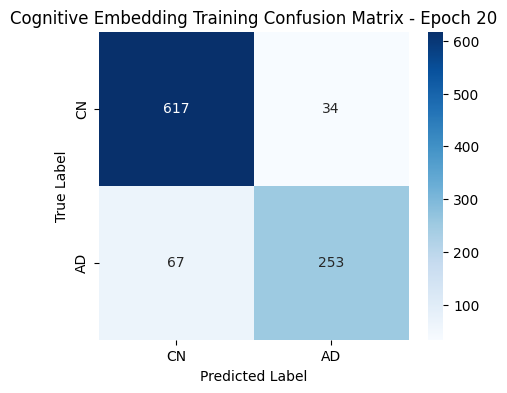

✅ Saved: /content/drive/Shareddrives/ECS289L/results/cognitive/training_cm


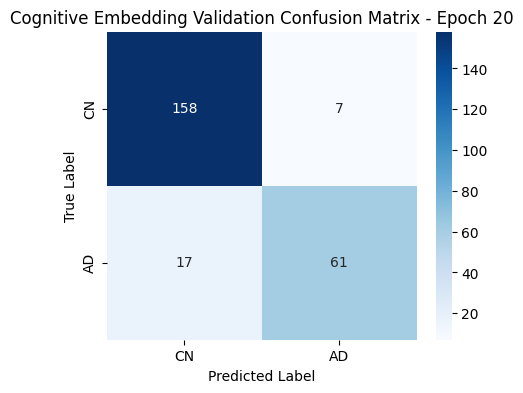

✅ Saved: /content/drive/Shareddrives/ECS289L/results/cognitive/validation_cm


In [200]:
# Example: plot confusion matrices for the last epoch
last_epoch = num_epochs - 1

# Training confusion matrix
plot_confusion_matrix(
    c_all_train_targets[last_epoch],
    c_all_train_preds[last_epoch],
    class_names=['CN', 'AD'],
    title=f'Cognitive Embedding Training Confusion Matrix - Epoch {last_epoch+1}',
    save_dir='/content/drive/Shareddrives/ECS289L/results/cognitive',
    name='training_cm'
)

# Validation confusion matrix
plot_confusion_matrix(
    c_all_val_targets[last_epoch],
    c_all_val_preds[last_epoch],
    class_names=['CN', 'AD'],
    title=f'Cognitive Embedding Validation Confusion Matrix - Epoch {last_epoch+1}',
    save_dir='/content/drive/Shareddrives/ECS289L/results/cognitive',
    name='validation_cm'
)

### Genetic

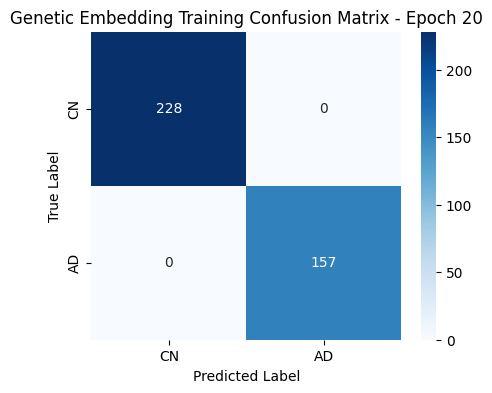

✅ Saved: /content/drive/Shareddrives/ECS289L/results/genetic1/training_cm


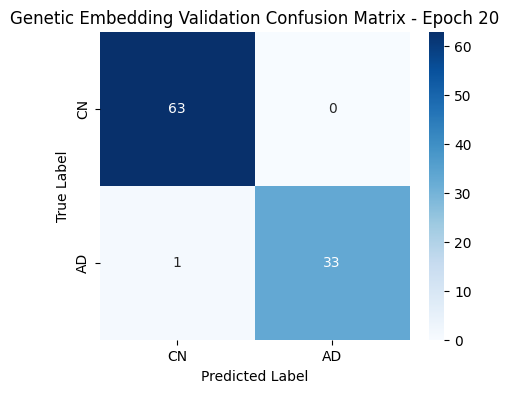

✅ Saved: /content/drive/Shareddrives/ECS289L/results/genetic1/validation_cm


In [201]:
# Training confusion matrix
plot_confusion_matrix(
    g_all_train_targets[last_epoch],
    g_all_train_preds[last_epoch],
    class_names=['CN', 'AD'],
    title=f'Genetic Embedding Training Confusion Matrix - Epoch {last_epoch+1}',
    save_dir='/content/drive/Shareddrives/ECS289L/results/genetic1',
    name='training_cm'
)

# Validation confusion matrix
plot_confusion_matrix(
    g_all_val_targets[last_epoch],
    g_all_val_preds[last_epoch],
    class_names=['CN', 'AD'],
    title=f'Genetic Embedding Validation Confusion Matrix - Epoch {last_epoch+1}',
    save_dir='/content/drive/Shareddrives/ECS289L/results/genetic1',
    name='validation_cm'
)


### MRI

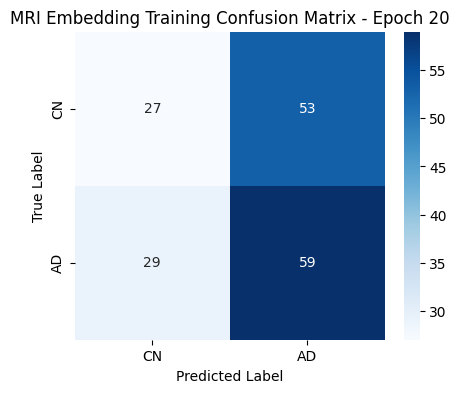

✅ Saved: /content/drive/Shareddrives/ECS289L/results/mri/training_cm


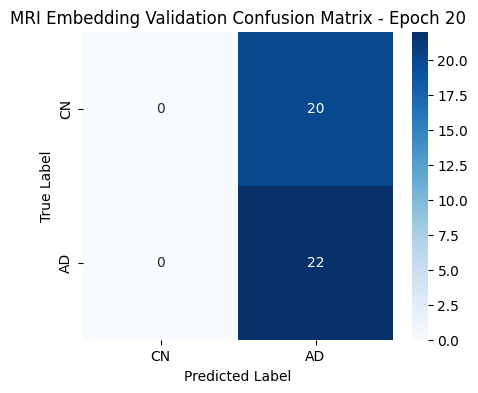

✅ Saved: /content/drive/Shareddrives/ECS289L/results/mri/validation_cm


In [203]:
# Training confusion matrix
plot_confusion_matrix(
    m_all_train_targets[last_epoch],
    m_all_train_preds[last_epoch],
    class_names=['CN', 'AD'],
    title=f'MRI Embedding Training Confusion Matrix - Epoch {last_epoch+1}',
    save_dir='/content/drive/Shareddrives/ECS289L/results/mri',
    name='training_cm'
)

# Validation confusion matrix
plot_confusion_matrix(
    m_all_val_targets[last_epoch],
    m_all_val_preds[last_epoch],
    class_names=['CN', 'AD'],
    title=f'MRI Embedding Validation Confusion Matrix - Epoch {last_epoch+1}',
    save_dir='/content/drive/Shareddrives/ECS289L/results/mri',
    name='validation_cm'
)


### Combined Confusion Matrices

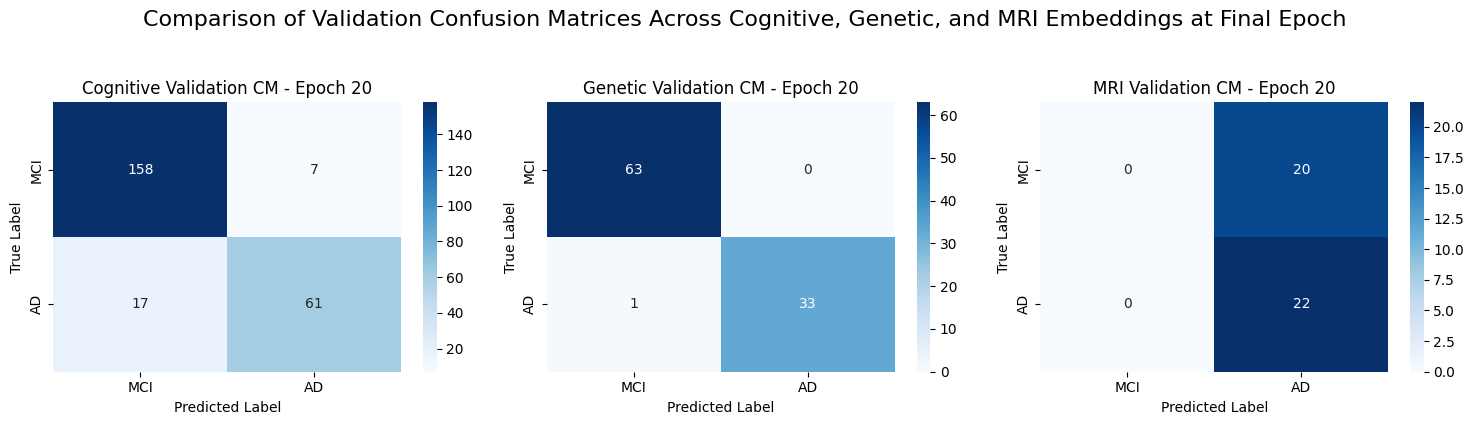

In [232]:
def plot_combined_confusion_matrices(true_labels_list, pred_labels_list, titles, class_names=['CN', 'AD'], save_path=None):
    n = len(true_labels_list)
    plt.figure(figsize=(5 * n, 4))

    # Add a main title for the entire figure
    plt.suptitle("Comparison of Validation Confusion Matrices Across Cognitive, Genetic, and MRI Embeddings at Final Epoch", fontsize=16, y=1.05)

    for i in range(n):
        cm = confusion_matrix(true_labels_list[i], pred_labels_list[i])
        plt.subplot(1, n, i + 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(titles[i])

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# Usage example:

last_epoch = num_epochs - 1
plot_combined_confusion_matrices(
    true_labels_list=[
        c_all_val_targets[last_epoch],
        g_all_val_targets[last_epoch],
        m_all_val_targets[last_epoch]
    ],
    pred_labels_list=[
        c_all_val_preds[last_epoch],
        g_all_val_preds[last_epoch],
        m_all_val_preds[last_epoch]
    ],
    titles=[
        f'Cognitive Validation CM - Epoch {last_epoch+1}',
        f'Genetic Validation CM - Epoch {last_epoch+1}',
        f'MRI Validation CM - Epoch {last_epoch+1}',
    ],
    class_names=['MCI', 'AD'],
    save_path='/content/drive/Shareddrives/ECS289L/results/single_modality_combined/combined_validation_cm.png'
)

## Training/Validation Accuracy + Loss

Cognitive

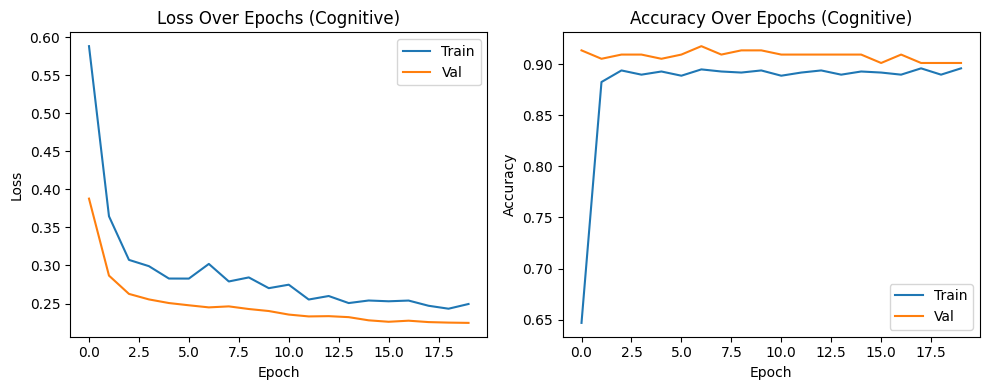

✅ Saved to Google Drive: /content/drive/Shareddrives/ECS289L/results/cognitive/loss_accuracy_over_epochs_cognitive.png


In [204]:
# Define save path
save_dir = '/content/drive/Shareddrives/ECS289L/results/cognitive'
os.makedirs(save_dir, exist_ok=True)

# Plot and Save Loss & Accuracy Curves
plt.figure(figsize=(10, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(c_train_losses, label='Train')
plt.plot(c_val_losses, label='Val')
plt.title('Loss Over Epochs (Cognitive)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(c_train_accuracies, label='Train')
plt.plot(c_val_accuracies, label='Val')
plt.title('Accuracy Over Epochs (Cognitive)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

# Save to Drive
save_path = os.path.join(save_dir, 'loss_accuracy_over_epochs_cognitive.png')
plt.savefig(save_path, bbox_inches='tight')
plt.show()
print(f"✅ Saved to Google Drive: {save_path}")


Genetic

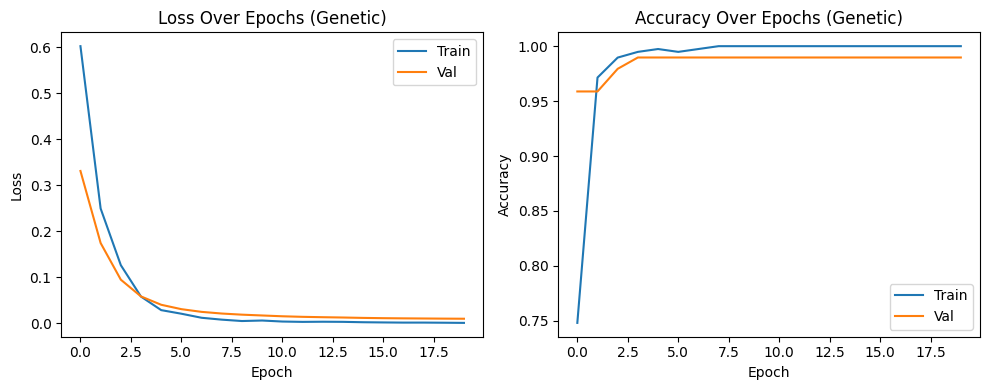

✅ Saved to Google Drive: /content/drive/Shareddrives/ECS289L/results/genetic1/loss_accuracy_over_epochs_genetic.png


In [205]:
# Define save path
save_dir = '/content/drive/Shareddrives/ECS289L/results/genetic1'
os.makedirs(save_dir, exist_ok=True)

# Plot and Save Genetic Loss & Accuracy Curves
plt.figure(figsize=(10, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(g_train_losses, label='Train')
plt.plot(g_val_losses, label='Val')
plt.title('Loss Over Epochs (Genetic)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(g_train_accuracies, label='Train')
plt.plot(g_val_accuracies, label='Val')
plt.title('Accuracy Over Epochs (Genetic)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

# Save to Drive
save_path = os.path.join(save_dir, 'loss_accuracy_over_epochs_genetic.png')
plt.savefig(save_path, bbox_inches='tight')
plt.show()
print(f"✅ Saved to Google Drive: {save_path}")

MRI

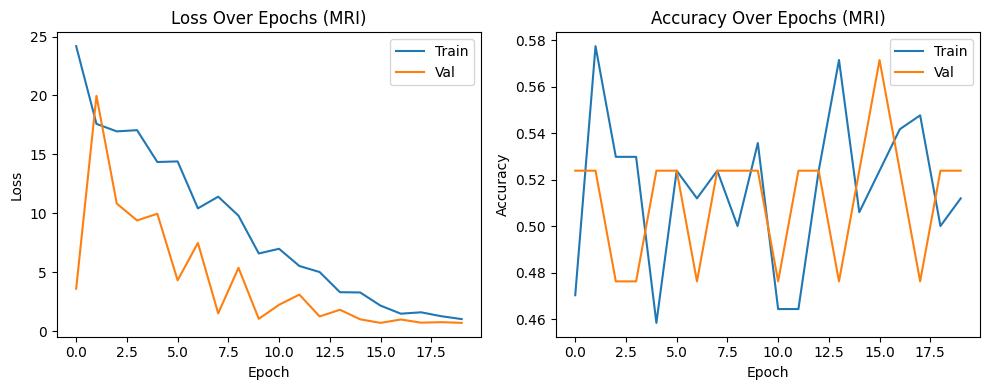

✅ Saved to Google Drive: /content/drive/Shareddrives/ECS289L/results/mri/loss_accuracy_over_epochs_mri.png


In [206]:
# Define save path
save_dir = '/content/drive/Shareddrives/ECS289L/results/mri'
os.makedirs(save_dir, exist_ok=True)

# Plot and Save MRI Loss & Accuracy Curves
plt.figure(figsize=(10, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(m_train_losses, label='Train')
plt.plot(m_val_losses, label='Val')
plt.title('Loss Over Epochs (MRI)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(m_train_accuracies, label='Train')
plt.plot(m_val_accuracies, label='Val')
plt.title('Accuracy Over Epochs (MRI)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

# Save to Drive
save_path = os.path.join(save_dir, 'loss_accuracy_over_epochs_mri.png')
plt.savefig(save_path, bbox_inches='tight')
plt.show()
print(f"✅ Saved to Google Drive: {save_path}")

## F1 and AUC Graphs

Cognitive

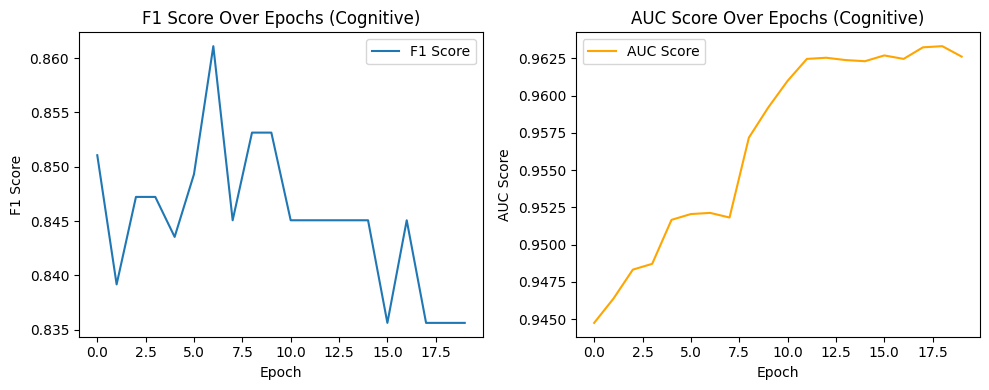

✅ Saved to Google Drive: /content/drive/Shareddrives/ECS289L/results/cognitive/f1_auc_over_epochs_cognitive.png


In [207]:
# Define save directory and ensure it exists
save_dir = '/content/drive/Shareddrives/ECS289L/results/cognitive'
os.makedirs(save_dir, exist_ok=True)

# Plot F1 and AUC Scores
plt.figure(figsize=(10, 4))

# F1 Score
plt.subplot(1, 2, 1)
plt.plot(c_f1_scores, label='F1 Score')
plt.title('F1 Score Over Epochs (Cognitive)')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# AUC Score
plt.subplot(1, 2, 2)
plt.plot(c_auc_scores, label='AUC Score', color='orange')
plt.title('AUC Score Over Epochs (Cognitive)')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.legend()

plt.tight_layout()

# Save the figure
save_path = os.path.join(save_dir, 'f1_auc_over_epochs_cognitive.png')
plt.savefig(save_path, bbox_inches='tight')
plt.show()

print(f"✅ Saved to Google Drive: {save_path}")

Genetic

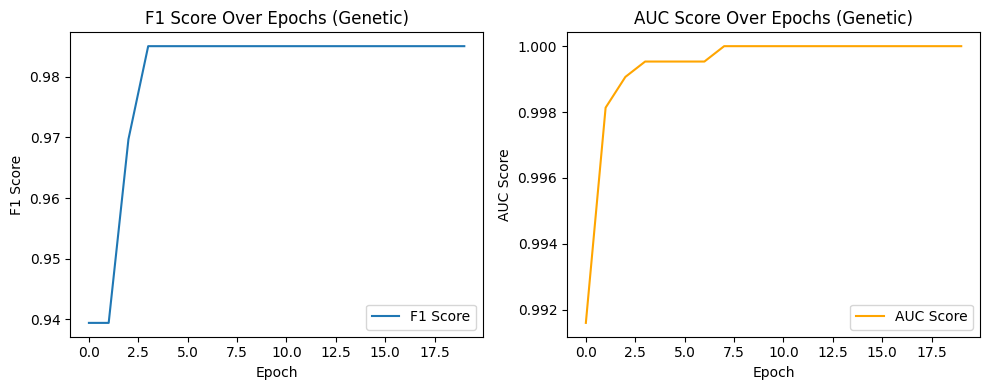

✅ Saved to Google Drive: /content/drive/Shareddrives/ECS289L/results/genetic1/f1_auc_over_epochs_genetic.png


In [208]:
# Define save directory and ensure it exists
save_dir = '/content/drive/Shareddrives/ECS289L/results/genetic1'
os.makedirs(save_dir, exist_ok=True)

# Plot F1 and AUC Scores
plt.figure(figsize=(10, 4))

# F1 Score
plt.subplot(1, 2, 1)
plt.plot(g_f1_scores, label='F1 Score')
plt.title('F1 Score Over Epochs (Genetic)')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# AUC Score
plt.subplot(1, 2, 2)
plt.plot(g_auc_scores, label='AUC Score', color='orange')
plt.title('AUC Score Over Epochs (Genetic)')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.legend()

plt.tight_layout()

# Save the figure
save_path = os.path.join(save_dir, 'f1_auc_over_epochs_genetic.png')
plt.savefig(save_path, bbox_inches='tight')
plt.show()

print(f"✅ Saved to Google Drive: {save_path}")


MRI

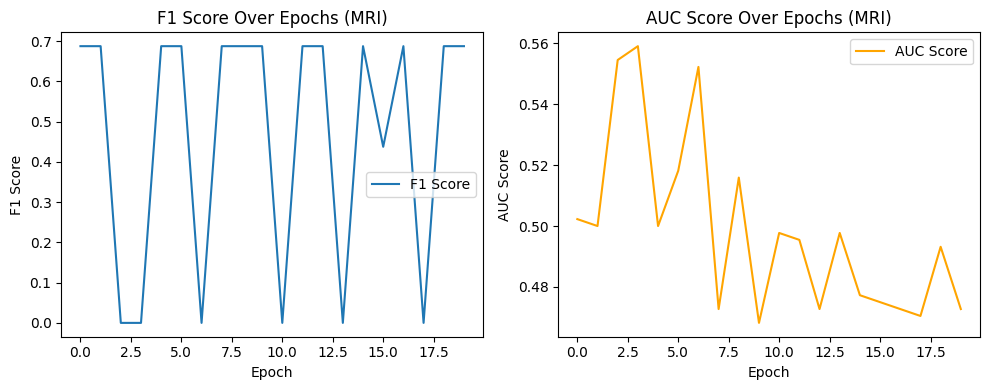

✅ Saved to Google Drive: /content/drive/Shareddrives/ECS289L/results/mri/f1_auc_over_epochs_mri.png


In [209]:
# Define save directory and ensure it exists
save_dir = '/content/drive/Shareddrives/ECS289L/results/mri'
os.makedirs(save_dir, exist_ok=True)

# Plot F1 and AUC Scores
plt.figure(figsize=(10, 4))

# F1 Score
plt.subplot(1, 2, 1)
plt.plot(m_f1_scores, label='F1 Score')
plt.title('F1 Score Over Epochs (MRI)')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# AUC Score
plt.subplot(1, 2, 2)
plt.plot(m_auc_scores, label='AUC Score', color='orange')
plt.title('AUC Score Over Epochs (MRI)')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.legend()

plt.tight_layout()

# Save the figure
save_path = os.path.join(save_dir, 'f1_auc_over_epochs_mri.png')
plt.savefig(save_path, bbox_inches='tight')
plt.show()

print(f"✅ Saved to Google Drive: {save_path}")

## Sensitivity and Specificity Graphs


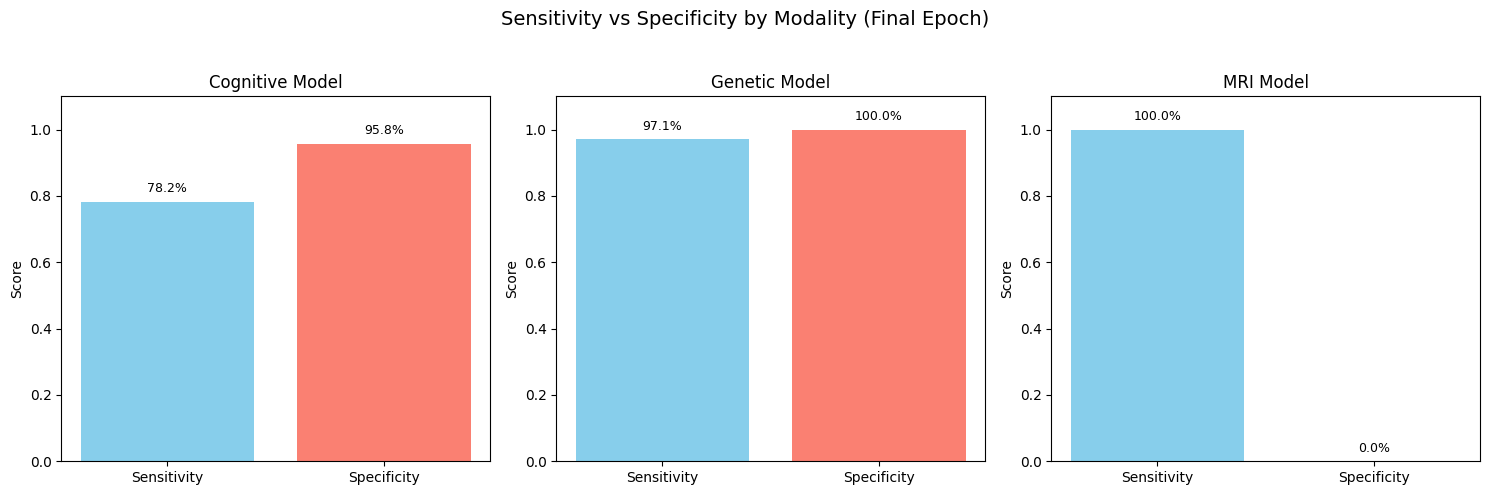

In [228]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def compute_sens_spec(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    return sensitivity, specificity

# Compute metrics for all 3 models
c_sens, c_spec = compute_sens_spec(c_all_val_targets[last_epoch], c_all_val_preds[last_epoch])
g_sens, g_spec = compute_sens_spec(g_all_val_targets[last_epoch], g_all_val_preds[last_epoch])
m_sens, m_spec = compute_sens_spec(m_all_val_targets[last_epoch], m_all_val_preds[last_epoch])

# Set up plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
titles = ['Cognitive', 'Genetic', 'MRI']
all_scores = [(c_sens, c_spec), (g_sens, g_spec), (m_sens, m_spec)]
colors = [['skyblue', 'salmon']] * 3

for ax, (sens, spec), title, color in zip(axs, all_scores, titles, colors):
    bars = ax.bar(['Sensitivity', 'Specificity'], [sens, spec], color=color)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, height + 0.02, f'{height*100:.1f}%', ha='center', va='bottom', fontsize=9)
    ax.set_ylim(0, 1.1)
    ax.set_title(f'{title} Model')
    ax.set_ylabel('Score')

plt.suptitle('Sensitivity vs Specificity by Modality (Final Epoch)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('/content/drive/Shareddrives/ECS289L/results/single_modality_combined/sens_spec_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
